# Supervised Classification with Quantum-Enhanced Support Vector Machines

### Introduction
Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists on applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabelled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

### construct dataset

In [1]:
from AI_qsvm_datasets import *
from qiskit_aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit_aqua.input import get_input_instance
from qiskit_aqua import run_algorithm

import logging
from qiskit_aqua._logging import set_logging_config, build_logging_config
set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

First we prepare the dataset, which is used for training, testing and the final prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

In [2]:
feature_dim = 2
sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, test_size=10, n=feature_dim, gap=0.3, PLOT_DATA=False)

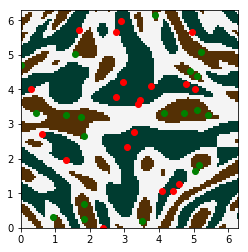

In [3]:
%matplotlib inline
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.scatter(training_input['A'][:,0], training_input['A'][:,1], c='r')
plt.scatter(training_input['B'][:,0], training_input['B'][:,1], c='g')
plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
           cmap='BrBG', extent=[0, 2*np.pi, 2*np.pi, 0])

With the dataset ready we begin using Aqua to train a quantum SVM.

### craft Aqua pipeline

In [4]:
# the feature map: IZ, ZI, ZZ
from qiskit_aqua.algorithms.components.feature_maps.second_order_expansion import SecondOrderExpansion
feature_map = SecondOrderExpansion()
feature_map.init_args(num_qubits=2, depth=2, entanglement='linear')

2018-11-05 21:01:43,666:qiskit_aqua.algorithms.components.feature_maps.pauli_expansion:INFO: Pauli terms include: ['ZI', 'IZ', 'ZZ']


In [5]:
# the algorithm: QSVM_Kernel
from qiskit_aqua.algorithms.many_sample.qsvm.qsvm_kernel import QSVM_Kernel
from qiskit.backends.aer import QasmSimulator
simulator = QasmSimulator()
algorithm = QSVM_Kernel()
algorithm.setup_quantum_backend(backend=simulator)
algorithm.init_args(training_dataset=training_input,
                    test_dataset=None,
                    datapoints=None,
                    feature_map=feature_map)
algorithm.enable_circuit_summary()

2018-11-05 21:01:44,698:qiskit_aqua.quantumalgorithm:INFO: Qiskit Terra version 0.7.0
2018-11-05 21:01:44,700:qiskit_aqua.quantumalgorithm:INFO: Algorithm: 'QSVM.Kernel' setup with backend 'qasm_simulator', with following setting:
 {'shots': 1024, 'skip_transpiler': False, 'config': {'noise_params': None}, 'basis_gates': 'u0,u1,u2,u3,cx,cz,id,x,y,z,h,s,sdg,t,tdg,rzz,snapshot,wait,noise,save,load', 'coupling_map': 'all-to-all', 'initial_layout': None, 'max_credits': 10, 'seed': None, 'qobj_id': None, 'hpc': None}
{'timeout': None}


In [6]:
# builds circuits, runs them to find the kernel matrix
# then solves quadratic programming to find the support vectors
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)
algorithm.train(data=datapoints[0], labels=datapoints[1])

2018-11-05 21:02:38,046:qiskit_aqua.utils.run_circuits:DEBUG: Submitting 780 circuits.
0-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
1-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
2-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
3-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
4-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
5-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
6-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
7-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
8-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
9-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
10-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
11-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
12-th circuit: 2 qubits, 2 classica

2018-11-05 21:02:39,041:qiskit_aqua.utils.qpsolver:DEBUG: Solving QP problem is completed.


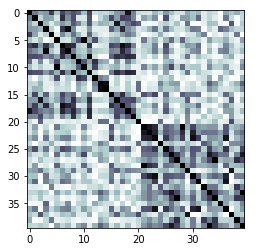

In [8]:
# block diagonal pattern because in the data A comes first, then B
# [[DARK, LIGHT], [LIGHT, DARK]] --> this means the kernel was good and could separate 
kernel_matrix = algorithm.ret['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest',
                 origin='upper', cmap='bone_r')
plt.show()

In [9]:
# support vectors
algorithm.ret['svm']

{'alphas': array([2.57376713, 1.36910292, 4.22498407, 0.13205944, 2.44737854,
        3.27839831, 3.41994512, 5.47179519, 0.09867272, 1.07325357,
        0.38570515, 2.53474864, 1.0416128 ]),
 'bias': array([-0.14733396]),
 'support_vectors': array([[3.89557489, 1.31946891],
        [2.0106193 , 3.51858377],
        [0.81681409, 1.44513262],
        [4.77522083, 3.45575192],
        [5.2150438 , 1.94778745],
        [5.59203492, 6.22035345],
        [5.59203492, 3.51858377],
        [5.34070751, 5.40353936],
        [3.20442451, 0.56548668],
        [4.0212386 , 2.57610598],
        [5.15221195, 0.9424778 ],
        [2.45044227, 0.25132741],
        [2.95309709, 4.90088454]]),
 'yin': array([-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])}

In [10]:
# takes SV that were found, and then uses those to classify the new test data
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
algorithm.enable_circuit_summary()
algorithm.test(data=datapoints[0], labels=datapoints[1])

2018-11-05 14:04:41,517:qiskit_aqua.utils.run_circuits:DEBUG: Submitting 260 circuits.
0-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
1-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
2-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
3-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
4-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
5-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
6-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
7-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
8-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
9-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
10-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
11-th circuit: 2 qubits, 2 classical bits and 31 operations with depth 22
12-th circuit: 2 qubits, 2 classica

2018-11-05 14:04:41,871:qiskit_aqua.algorithms.many_sample.qsvm.qsvm_kernel_binary:DEBUG: Classification success for this set is 100.00% 



1.0

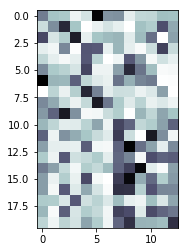

In [11]:
kernel_matrix_testing = algorithm.ret['kernel_matrix_testing']
img = plt.imshow(np.asmatrix(kernel_matrix_testing), interpolation='nearest',
                 origin='upper', cmap='bone_r')
plt.show()

In [12]:
algorithm.ret['testing_accuracy']

1.0

### [optional] inspect circuits that were run

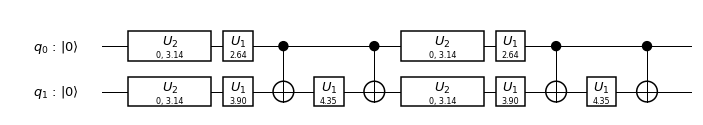

In [7]:
# see the actual circuits
circuit = feature_map.construct_circuit(datapoints[0][0])
from qiskit.tools.visualization import *
circuit_drawer(circuit, output='mpl')

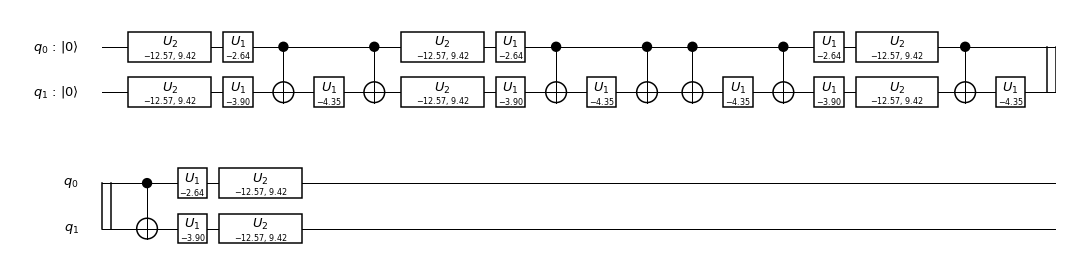

In [10]:
# concatenate with the inverse circuit to get expectation value
from qiskit import QuantumCircuit
inv_circuit = QuantumCircuit()
inv_circuit.data = [x.inverse() for x in reversed(circuit.data)]
circuit_drawer(circuit + inv_circuit, output='mpl')

### The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal componenets as features.

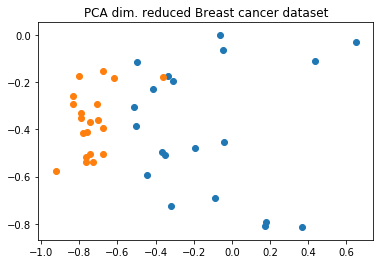

{'A': 0, 'B': 1} {0: 'A', 1: 'B'}


In [13]:
feature_dim = 2
sample_Total, training_input, test_input, class_labels = Breast_cancer(
    training_size=20, test_size=10, n=feature_dim, PLOT_DATA=True)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
label_to_class = {label:class_name for class_name, label in class_to_label.items()}
print(class_to_label, label_to_class)

In [14]:
params = {
    'problem': {'name': 'svm_classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM.Kernel'
    },
    'backend': {'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}

In [15]:
algo_input = get_input_instance('SVMInput')
algo_input.training_dataset  = training_input
algo_input.test_dataset = test_input
algo_input.datapoints = datapoints[0]
result = run_algorithm(params, algo_input)
print("testing success ratio: ", result['testing_accuracy'])
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], label_to_class)))
print("predicted:    {}".format(result['predicted_classes']))

2018-11-05 14:05:21,427:qiskit_aqua._discover:DEBUG: Failed to load qiskit_aqua.algorithms.classical.cplex.cplex_ising error CPLEX is not installed. See https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.studio.help/Optimization_Studio/topics/COS_home.html
2018-11-05 14:05:21,434:qiskit_aqua._discover:DEBUG: Failed to load qiskit_aqua.algorithms.classical.cplex.simple_cplex error CPLEX is not installed. See https://www.ibm.com/support/knowledgecenter/SSSA5P_12.8.0/ilog.odms.studio.help/Optimization_Studio/topics/COS_home.html
2018-11-05 14:05:21,588:qiskit_aqua._discover:DEBUG: Failed to load qiskit_aqua.algorithms.components.optimizers.nlopts._nloptimizer error No module named 'nlopt'
2018-11-05 14:05:21,591:qiskit_aqua._discover:DEBUG: Failed to load qiskit_aqua.algorithms.components.optimizers.nlopts.crs error No module named 'nlopt'
2018-11-05 14:05:21,596:qiskit_aqua._discover:DEBUG: Failed to load qiskit_aqua.algorithms.components.optimizers.nlopts.direct_l error

2018-11-05 14:05:21,738:qiskit_aqua.algomethods:DEBUG: Algorithm Input: {
    "algorithm": {
        "name": "QSVM.Kernel"
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "hpc_params": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "noise_params": null,
        "shots": 1024,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "linear",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "problem": {
        "name": "svm_classification",
        "random_seed": 10598
    }
}
2018-11-05 14:05:22,688:qiskit_aqua.quantumalgorithm:DEBUG: Registered with Qiskit successfully.
2018-11-05 14:05:22,690:qiskit_aqua.quantumalgorithm

testing success ratio:  0.8
ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
predicted:    ['A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B']


kernel matrix during the training:


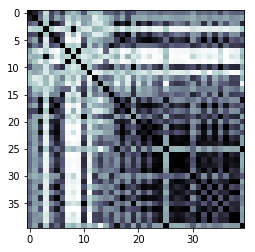

In [16]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()